In [1]:
# pip install evalml

In [2]:
import evalml
from evalml import AutoMLSearch
from evalml.data_checks import DataCheckActionCode
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

In [3]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '2f5a6780-2fed-47cc-a89a-efd6b03243cc'
resource_group = 'ml_for_ccfd'
workspace_name = 'ml_for_ccfd_ws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Capstone_CCFD')
df=dataset.to_pandas_dataframe()

In [4]:
start_time = time.time()

problem_type = 'binary'
target_column = 'Class'  

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

automl = evalml.AutoMLSearch(X_train=X_train, y_train=y_train, problem_type=problem_type)

automl.search()

best_pipeline = automl.best_pipeline

best_pipeline.fit(X_train, y_train)

pipeline = BinaryClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Imputer': ['Imputer', 'X', 'Label Encoder.y'], 'Undersampler': ['Undersampler', 'Imputer.x', 'Label Encoder.y'], 'Select Columns Transformer': ['Select Columns Transformer', 'Undersampler.x', 'Undersampler.y'], 'XGBoost Classifier': ['XGBoost Classifier', 'Select Columns Transformer.x', 'Undersampler.y']}, parameters={'Label Encoder':{'positive_label': None}, 'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'Undersampler':{'sampling_ratio': 0.25, 'min_samples': 100, 'min_percentage': 0.1, 'sampling_ratio_dict': None}, 'Select Columns Transformer':{'columns': ['V1', 'V4', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V26']}, 'XGBoost Classifier':{'eta': 0.1, 'max_depth': 6, 

In [5]:
end_time = time.time()

num_samples_test = len(y_test)
print(f"Number of samples in the test set: {num_samples_test} \n")

Workflow_Runtime = end_time - start_time
print(f"\nAutoML Workflow Runtime: {Workflow_Runtime:.2f} seconds")

Number of samples in the test set: 56962 


AutoML Workflow Runtime: 28.96 seconds


In [6]:
start_time = time.time()
y_predicted = best_pipeline.predict(X_test)
end_time = time.time()

accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

confusion_matrix_result = confusion_matrix(y_test, y_predicted)

num_samples_test = len(y_test)
print(f"Number of samples in the test set: {num_samples_test} \n")

Prediction_Time = end_time - start_time
print(f"\nPrediction Time: {Prediction_Time:.2f} seconds \n")

print("Evaluation Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}\n")

print("Confusion Matrix:")
print(confusion_matrix_result)

Number of samples in the test set: 56962 


Prediction Time: 0.35 seconds
Evaluation Metrics on Test Data:
Accuracy: 0.9994
Precision: 0.8333
Recall: 0.8163
F1-Score: 0.8247

Confusion Matrix:
[[56848    16]
 [   18    80]]


Number of samples in the test set: 56962 


Prediction Time: 0.35 seconds


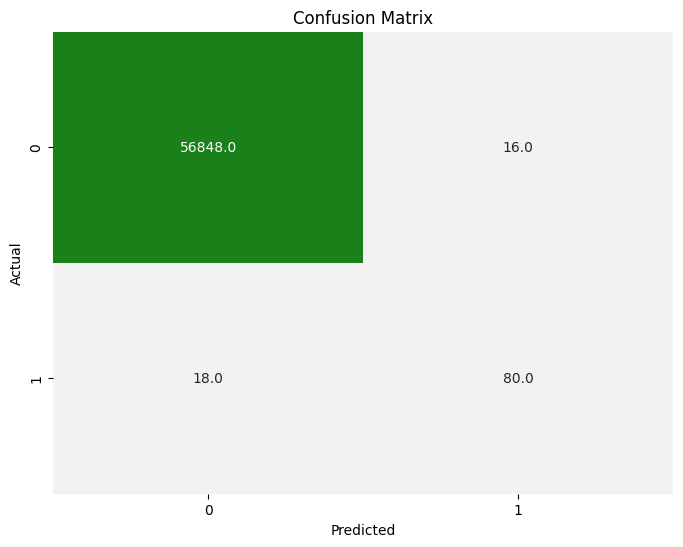

In [7]:
num_samples_test = len(y_test)
print(f"Number of samples in the test set: {num_samples_test} \n")

Prediction_Time = end_time - start_time
print(f"\nPrediction Time: {Prediction_Time:.2f} seconds")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

TN = confusion_matrix_result[0][0]
TP = confusion_matrix_result[1][1]
FP = confusion_matrix_result[0][1]
FN=confusion_matrix_result[1][0]

confusion_matrix_data = np.array([[TN, FP], [FN, TP]])
tn, fp, fn, tp = confusion_matrix_data.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

fig, ax = plt.subplots(figsize=(8, 6))

colors = [(0.95, 0.95, 0.95), (0.1, 0.5, 0.1)]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(confusion_matrix_data, annot=True, fmt='.1f', cmap=cmap, ax=ax, cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

plt.show()